# Effect of Rain on Subway Ridership on Weekdays
# Nick Garvey

In [240]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import pandas as pd
import numpy as np
import scipy as sp
import ggplot as gp
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import statsmodels.formula.api as sm

%matplotlib inline

In [241]:
# Data Source: https://www.dropbox.com/s/
# meyki2wl9xfa7yk/turnstile_data_master_with_weather.csv

df = pd.read_csv('turnstile_weather_v2.csv')

## 1. Statistical Test

First, check if the data is normal by graphing it.

In [242]:
# Monday is 0, ... Saturday is 5, Sunday is 6
week_days = df[pd.to_datetime(df['DATEn']).dt.dayofweek < 5]
week_days = week_days[['station', 'DATEn', 'rain', 'ENTRIESn_hourly']]
grouped_days = week_days.groupby(['station', 'DATEn'])

# Add a column, rainy, that annotates if it was rainy at that station at all during that day
def add_rainy_day(group):
    group['rainy_day'] = 1 in group['rain'].values
    return group

df_with_rainy = grouped_days.apply(add_rainy_day)
by_day = df_with_rainy.groupby(['DATEn', 'station', 'rainy_day'], as_index=False)
by_day = by_day['ENTRIESn_hourly'].sum()

rain = by_day[by_day['rainy_day'] == True]['ENTRIESn_hourly']
no_rain = by_day[by_day['rainy_day'] == False]['ENTRIESn_hourly']

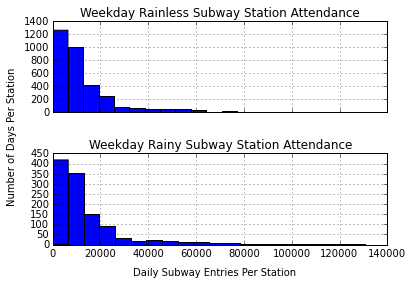

In [243]:
fig, axes = plt.subplots(2, sharex=True)

no_rain.hist(ax=axes[0], bins=20).set_title('Weekday Rainless Subway Station Attendance')
rain.hist(ax=axes[1], bins=20).set_title('Weekday Rainy Subway Station Attendance')
fig.subplots_adjust(hspace=.45)

# Apply the labels just as text as it isn't obvious how to share a label among two subplots
# Code from http://stackoverflow.com/a/26892326/965648
fig.text(0.5, 0.02, 'Daily Subway Entries Per Station', ha='center')
fig.text(0.02, 0.5, 'Number of Days Per Station', va='center', rotation='vertical')

plt.show()

Data is clearly not normal, so use the Mann-Whitney U Test to compare the two samples.

Null hypothesis: The hourly entry rate is the same on rainy and non-rainy days.
Alternative hypothesis: The hourly entry rate is different on rainy and non-rainy days.

In [244]:
U, p = sp.stats.mannwhitneyu(rain, no_rain)

print('Mean hourly entries on a rainy day:', rain.mean())
print('Mean hourly entries on a non-rainy day:', no_rain.mean())
print('U statistic:', U)
print('Probability difference is due to chance:', p)

Mean hourly entries on a rainy day: 15091.9598291
Mean hourly entries on a non-rainy day: 14280.8696556
U statistic: 1914829.0
Probability difference is due to chance: 0.0754622901355


Due to the P value of 7.5%, we fail to reject the null.

## 2. Linear Regression

In [245]:
# Produce a dataset that groups all of the entries at a particular time together
# This way, the station/unit isn't considered

total_hourly_entries = \
    df.groupby(['weekday', 'hour', 'rain'], as_index=False)[['ENTRIESn_hourly']].mean()

y = total_hourly_entries['ENTRIESn_hourly']
x = total_hourly_entries[['hour', 'weekday', 'rain']]
# This is just statsmodel OLS, but we use the pandas interface to it
print(pd.stats.ols.OLS(y, x))


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <hour> + <weekday> + <rain> + <intercept>

Number of Observations:         24
Number of Degrees of Freedom:   4

R-squared:         0.5588
Adj R-squared:     0.4926

Rmse:            844.0648

F-stat (3, 20):     8.4422, p-value:     0.0008

Degrees of Freedom: model 3, resid 20

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          hour   101.2211    25.2213       4.01     0.0007    51.7874   150.6547
       weekday  1046.1914   344.5880       3.04     0.0065   370.7989  1721.5838
          rain   -15.4076   344.5880      -0.04     0.9648  -690.8001   659.9848
     intercept   108.0618   390.7261       0.28     0.7850  -657.7613   873.8848
---------------------------------End of Summary---------

The above ordinary least squares analysis shows that 55.2% of the variance in the global hourly subway entries is explained by the hour and if it is a weekday. This suggests a good relationship between if it is weekday, the time of day, and the number of people that enter the subway in New York City at that time.

Because station is a large factor in the number of subway entries, we needed to include it in our analysis. It isn't a numerical variable, so the easiest way to include it was to just aggregrate across all stations.

The regression was done using hour and weekday as independent variables. They were chosen as habit and routine are the most likely significant driver of subway usage. Including weather data didn't noticeably increase the R-squared value. Perhaps this is because each station has its own weather and we aggregrated across all stations.

## 3. Visualization

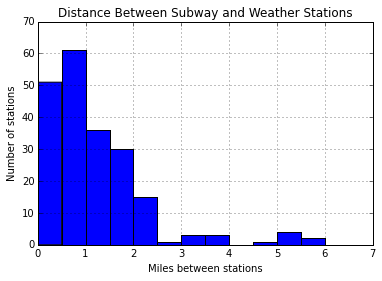

In [246]:
# Our goal is to show how close the weather stations are to the subway stations that they provide
# weather data for. To do this, we use the latitude and longitude of each to determine where they are
# on the Earth. From these points, we use the Haversine formula to calculate the distance. While this
# formula assumes the Earth is a sphere, it should be more than good enough for our purposes

# Formula from http://en.wikipedia.org/wiki/Haversine_formula
# Implementation my own
def haversine(radius, lat1, lat2, lon1, lon2):
    """Haversine formula. All angle variables are in radians"""
    inner = np.sqrt(np.sin((lat2 - lat1)/2)**2
                    + (np.cos(lat1) * np.cos(lat2) * np.sin((lon2 - lon1)/2)**2))
    return 2 * radius * np.arcsin(inner)

# This function was tested by plugging some values into this and
# comparing with Google Maps walking distance
def earth_distance(row):
    """Variables are GPS coordinates"""
    # Average Earth radius
    EARTH_RADIUS_MILES = 3959
    return haversine(EARTH_RADIUS_MILES, *np.deg2rad(row))

coords = df.groupby('station')[['latitude', 'weather_lat', 'longitude', 'weather_lon']]
per_station_coords = coords.last()
per_station_coords['dist'] = \
    np.apply_along_axis(earth_distance, 1, per_station_coords.values)

axis = per_station_coords['dist'].hist(bins=np.arange(0, 7, .5))
axis.set_xlabel('Miles between stations')
axis.set_ylabel('Number of stations')
axis.set_title('Distance Between Subway and Weather Stations')
None

The above visualization shows the distance between the weather station and the subway station it provides data for. Large distances suggest the weather data is not as representative of the actual weather near the subway station. Luckily, all of the weather stations are within 6 miles, with the vast majority being within 2.5 miles.

In [247]:
# These calculations are used in the sections below
coord_list = per_station_coords[['latitude', 'longitude']].values
max_dist = max([earth_distance([x[0], y[0], x[1], y[1]])
                for x in coord_list for y in coord_list])
print("Maximum distance between two stations: {:.2f} miles".format(max_dist))

has_data = not df[(df['station'] == 'CYPRESS HILLS')
                  & (df['datetime'] == '5/6/11 8:00')].empty
print("Exists data for Cypress Hills at 5/6/11 8:00am: {}".format(has_data))

Maximum distance between two stations: 22.01 miles
Exists data for Cypress Hills at 5/6/11 8:00am: False


## 4. Conclusion

It does not appear that there is a statistically significant relationship between rain and subway ridership. The Mann-Whitney U Test between means had a p-value of 7.5%, which is too high to be significant. Mann-Whitney U Test performed compared the mean weekday daily ridership between stations. However, this is sensitive to noise. If a busy station had a couple of rainy days, the rainy mean could be brought up significantly. The effect of this could be reduced if more than a month of data was used.

The ordinary least squares regression also suggested against rain being a factor. It only appeared to impact global daily ridership by about 16 people, as the coefficient was -15.4. The p-value was also very high, suggesting that -15.4 was just noise.

## 5. Reflection

The dataset used is only from the month of May in 2011. One month is not a lot of data, a couple of baseball games could throw off these numbers significantly. This is the largest weakness of this dataset. More data across a larger frame would greatly increase its usefulness.

There also appears to be missing data points. For example, Cypress Hills doesn't have any value at 5/6/11 at 8:00am. This throws off calculations like per-station daily values that were used in the above analysis.

The analysis methods used were powerful but rudimentary. The dependent variables were picked based on a hunch. Only linear relationships between variables were considered. More complicated relationships likely exist. An r-squared value of .56 is good, but a better value is almost certainly achievable.